### Exploring the Global Flood Monitoring data with stac and xarray


In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import pyproj
from pystac_client import Client
from odc.stac import stac_load
import xarray as xr

The pystac_client allows us to explore the data of interest with (or without) a given area and time.

First, we select the dataset, bounding box and datetime.  

In [2]:
collection = "GFM"

bbox =  [15.6, 48.25, 16.2, 48.45]

date = ['2024-09-12T00:00:00Z', '2024-09-28T00:00:00Z']

The client creates a connection to EODC's stac api and finds data that matches the requested extents.

In [3]:
client = Client.open('https://stac.eodc.eu/api/v1')
results = client.search(collections=collection,
    max_items=100,
    bbox=bbox,
    datetime=date,
)
result_items = list(results.items())
result_items[:5]

[<Item id=ENSEMBLE_FLOOD_20240927T050214_VV_EU020M_E051N015T3>,
 <Item id=ENSEMBLE_FLOOD_20240927T050149_VV_EU020M_E051N015T3>,
 <Item id=ENSEMBLE_FLOOD_20240925T051858_VV_EU020M_E051N015T3>,
 <Item id=ENSEMBLE_FLOOD_20240925T051808_VV_EU020M_E051N015T3>,
 <Item id=ENSEMBLE_FLOOD_20240923T164341_VV_EU020M_E051N015T3>]

The stac items contain all the metadata provided, as shown in the example in the next cell:

In [4]:
result_items[0]

<Item id=ENSEMBLE_FLOOD_20240927T050214_VV_EU020M_E051N015T3>

We utilize odc's stac_load functionality to load the data as an xarray.DataArray. 

In the stac_load function, we need to define the coordinate reference system as well as the resolution. Both of these are specified in the item properties.

In [5]:
crs = pyproj.CRS.from_wkt(result_items[0].properties["proj:wkt2"])
resolution = result_items[0].properties["gsd"]

data = stac_load(
    result_items, 
    chunks={"x": 1000, "y": 1000}, 
    bands=["ensemble_flood_extent", "reference_water_mask"],
    crs=crs,
    resolution=resolution,
    dtype="uint8",
    bbox=bbox
    )

data

<xarray.Dataset> Size: 101MB
Dimensions:                (y: 1353, x: 2334, time: 16)
Coordinates:
  * y                      (y) float64 11kB 1.651e+06 1.651e+06 ... 1.624e+06
  * x                      (x) float64 19kB 5.214e+06 5.214e+06 ... 5.261e+06
    spatial_ref            int32 4B 0
  * time                   (time) datetime64[ns] 128B 2024-09-13T05:18:08 ......
Data variables:
    ensemble_flood_extent  (time, y, x) uint8 51MB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    reference_water_mask   (time, y, x) uint8 51MB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>

The nodata value is set to 255. For further calculation, we will set all 255 values to 0. 

In [6]:
data_0 = xr.where(data == 1, 1, 0)

We can calculate the flood frequency by taking the temporal mean. 

In [7]:
frequency = data_0.mean(dim="time")

In [8]:
flood_frequency = frequency.ensemble_flood_extent

flood_frequency

<xarray.DataArray 'ensemble_flood_extent' (y: 1353, x: 2334)> Size: 25MB
dask.array<mean_agg-aggregate, shape=(1353, 2334), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 11kB 1.651e+06 1.651e+06 ... 1.624e+06 1.624e+06
  * x            (x) float64 19kB 5.214e+06 5.214e+06 ... 5.261e+06 5.261e+06
    spatial_ref  int32 4B 0

The reference water mask represents permanent or seasonal water bodies, which are clearly distinct from flood events.

For the selected area, the reference water mask covers parts of the Danube. 

In [9]:
ref_water = frequency.reference_water_mask
ref_water = xr.where(ref_water == 1, 1, np.nan)

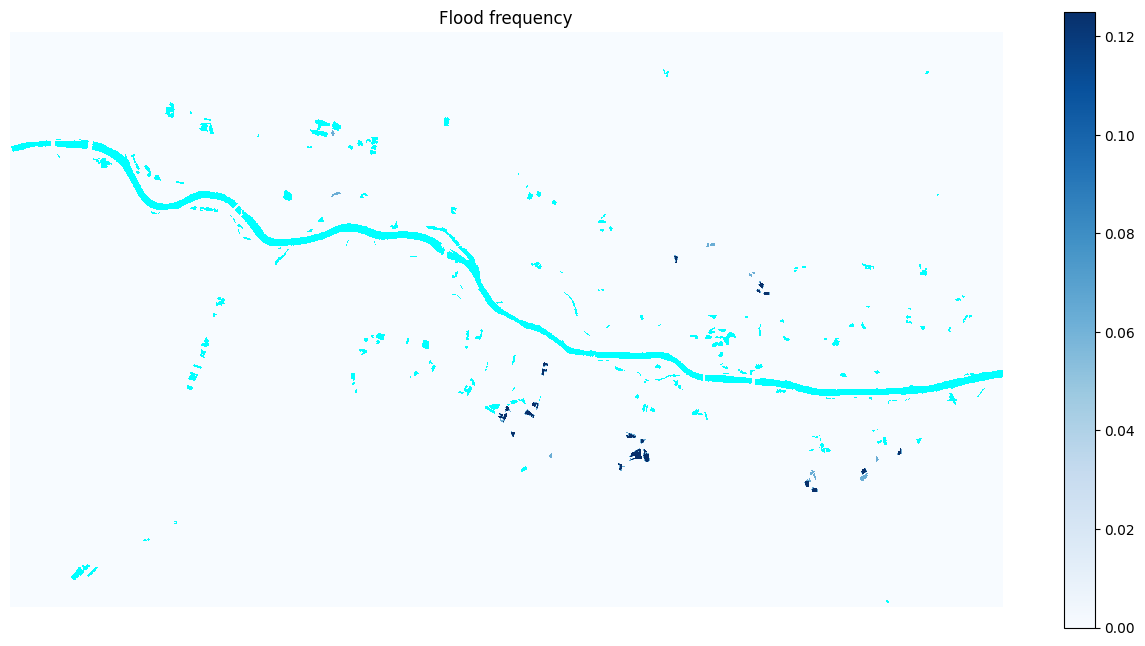

In [10]:
plt.figure(figsize=(16,8))
plt.imshow(flood_frequency, cmap="Blues", interpolation="nearest")
plt.title("Flood frequency")
plt.axis("off")
plt.colorbar()
plt.imshow(ref_water, cmap="cool", interpolation="nearest")
plt.show()

In this example, we calculated the flood frequency and displayed the data by using stac. There was no need to download any of the files provided. 

We could save the data as zarr:

In [11]:
data.to_zarr("./gfm.zarr")